<h4><p align = "center">Name : Hiten Gondaliya</p>
<p align = "center">ID : 202318063</p>


<p>Learn how to apply Spark for Document clustering using K-means and Hierarchical clustering techniques.</p>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, Word2Vec
from pyspark.ml.clustering import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Document clustering") \
    .getOrCreate()

24/03/27 17:19:49 WARN Utils: Your hostname, prince-Latitude-3500 resolves to a loopback address: 127.0.1.1; using 192.168.0.111 instead (on interface wlp0s20f3)
24/03/27 17:19:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/27 17:19:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<p><h4>-->Fetching dataset from sklearn</p>

In [ ]:
data_newsgroup = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Convert data into a DataFrame
data = pd.DataFrame({'text': data_newsgroup.data})

# Convert pandas DataFrame to Spark DataFrame
processed_data = spark.createDataFrame(data)


<p>We are taking the entire dataset and apply clustering algorithms to discover inherent structures or patterns within the data, so we don't need to split the dataset into training and testing sets as we do in supervised learning. Instead, we use the entire dataset for clustering.</p>
<p>data_newsgroup = fetch_20newsgroups(<u>subset='all'</u>, remove=('headers', 'footers', 'quotes'))</p>


<p><h4>-->representing each document using the TF-IDF</p>

In [ ]:
# Document Representation (TF-IDF)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(processed_data)
wordsData

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filteredData = remover.transform(wordsData)

In [ ]:
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
featurizedData = hashingTF.transform(filteredData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
tfidfData = idfModel.transform(featurizedData)

24/03/27 17:20:01 WARN TaskSetManager: Stage 0 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.


<h4><p>K-means Clustering</p>

In [ ]:
kmeans = KMeans(featuresCol="features").setK(5)
model = kmeans.fit(tfidfData)
predictions = model.transform(tfidfData)  #making predictions
tfidfData.select("features").show(truncate=False)

24/03/27 18:02:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 18:02:03 WARN TaskSetManager: Stage 256 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 18:02:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 18:02:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 18:02:06 WARN TaskSetManager: Stage 259 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 18:02:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 18:02:08 WARN TaskSetManager: Stage 260 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 18:02:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 18:02:08 WARN TaskSetManager: Stage 261 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<b>The silhouette score</b> is a metric used to evaluate the quality of clusters formed by a clustering algorithm. It provides a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1
<list>
<<ul>
<li>A score close to +1 indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters, suggesting a good clustering.</li>
<li>A score close to 0 indicates that the object is close to the decision boundary between two neighboring clusters.</li>
<li>A score close to -1 indicates that the object may have been assigned to the wrong cluster.</ul></list></li>

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# Evaluate silhouette score
silhouette_score = evaluator.evaluate(predictions)
print("Silhouette Score:", silhouette_score)

24/03/27 17:55:01 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
24/03/27 17:55:01 WARN TaskSetManager: Stage 251 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:55:04 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
24/03/27 17:55:04 WARN TaskSetManager: Stage 253 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score: 0.9946728690685919


In [ ]:
#  Finding optimal K for K-means (Elbow Method)
wcss = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol='features').setK(k).setSeed(1)
    model = kmeans.fit(tfidfData)
    wcss_value = model.summary.trainingCost
    # Get the WCSS (within-set sum of squared errors) from the summary
    wcss.append(wcss_value)

24/03/27 17:20:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 17:20:56 WARN TaskSetManager: Stage 24 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:20:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 17:20:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 17:20:58 WARN TaskSetManager: Stage 27 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:21:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 17:21:00 WARN TaskSetManager: Stage 28 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:21:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/03/27 17:21:00 WARN TaskSetManager: Stage 29 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24

In [ ]:
print("All K values along with their corresponding WCSS:")
for k, wcss_value in zip(range(2, 11), wcss):
    print(f"K = {k}, WCSS = {wcss_value}")

All K values along with their corresponding WCSS:
K = 2, WCSS = 376629526.65606886
K = 3, WCSS = 304170864.45074654
K = 4, WCSS = 282432707.2048134
K = 5, WCSS = 274179890.92507696
K = 6, WCSS = 258182891.3994578
K = 7, WCSS = 250297126.67463115
K = 8, WCSS = 240976138.064436
K = 9, WCSS = 238585449.51970348
K = 10, WCSS = 222928957.38044888


The WCSS generally decreases as the number of clusters(K) increases, This pattern is expected because increasing the number of clusters allows for better fitting of the data points, resulting in smaller within-cluster variations.

<p><h4>Elbow method:</p></h4>
<p>The Elbow Method is a heuristic used to find the optimal number of clusters (K) in a dataset for clustering algorithms.</p>

<h4><p>--> For each of the K-means clustering techniques use K(number of clusters) as a hyperparameter and find the WCSS for each k-value. Find the optimal number of clusters using the elbow method.</p>

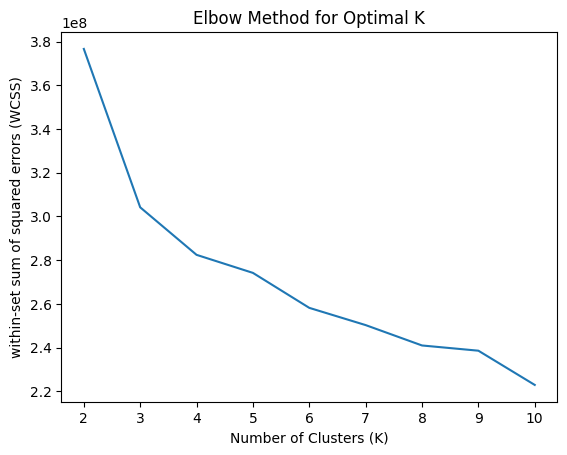

Optimal K value: 10


In [ ]:

# Plotting the elbow method
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('within-set sum of squared errors (WCSS)')
plt.show()
optimal_k = wcss.index(min(wcss)) + 2  # Add 2 because the range starts from 2
print("Optimal K value:", optimal_k)

<p>The WCSS values generally decrease as the number of clusters (K) increases. However, the rate of decrease slows down after a certain point (elbow point), indicating diminishing returns in terms of reducing WCSS. In this case, the elbow point is observed at K = 10, suggesting that adding more clusters beyond this point may not significantly improve the clustering performance.</p>

<p><h4>Agglomerative clustering for clustering the documents and find the optimal number of clusters using dendrogram diagrams.</p>

24/03/27 14:41:06 WARN TaskSetManager: Stage 193 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 14:41:06 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/03/27 14:41:06 WARN TaskSetManager: Stage 196 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.


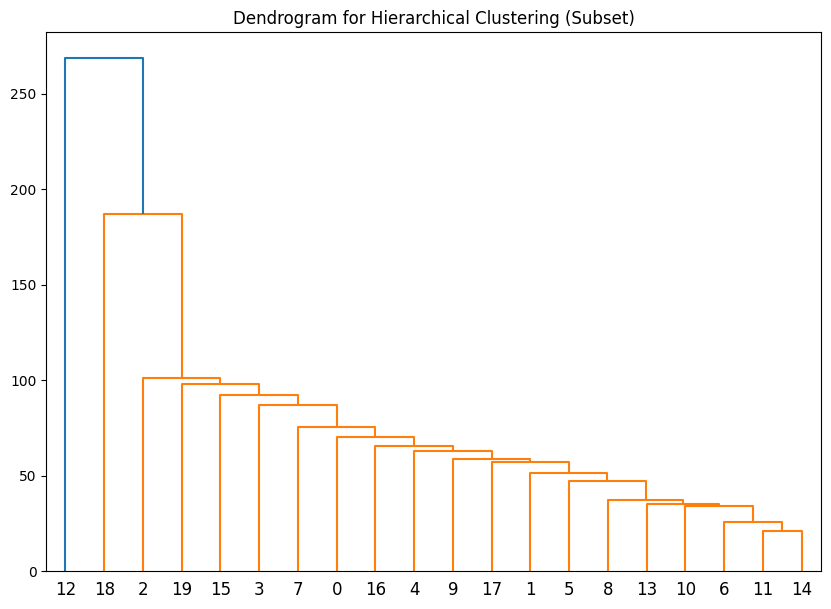

Optimal number of clusters (K): 20


In [ ]:
#Step 5: Hierarchical Clustering (Agglomerative) - Sampling Subset
# Sample a subset of the TF-IDF matrix
subset_size = 20  # Adjust the subset size as needed
subset_indices = np.random.choice(tfidfData.count(), size=subset_size, replace=False)
subset_features = tfidfData.select('features').take(subset_size)

# Convert subset features to array
subset_array = [row.features.toArray() for row in subset_features]

# Perform hierarchical clustering on the subset
Z = linkage(subset_array, method='ward')

# Plotting dendrogram for hierarchical clustering on the subset
plt.figure(figsize=(10, 7))
plt.title("Dendrogram for Hierarchical Clustering (Subset)")
dendrogram(Z)
plt.show()

num_vertical_lines = 0
for i in range(len(Z)):
    if Z[i][2] > 0:
        num_vertical_lines += 1

# Optimal number of clusters is the number of vertical lines + 1
optimal_k = num_vertical_lines + 1
print("Optimal number of clusters (K):", optimal_k)

In [ ]:
# # Step 5: Hierarchical Clustering (Agglomerative)
# features = tfidfData.select('features').rdd.map(lambda row: row[0]).collect()
# Z = linkage(features, method='ward')

# # Plotting dendrogram
# plt.figure(figsize=(10, 7))
# plt.title("Dendrogram for Hierarchical Clustering")
# dendrogram(Z)
# plt.show()

<h4><p>Naive Bayes Classification</p>

In [ ]:
# TF-IDF Vectorization for Naive Bayes classification
data = pd.DataFrame({'text': data_newsgroup.data, 'target': data_newsgroup.target})

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
y_pred_nb = nb_classifier.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Classification Accuracy:", accuracy_nb)

Naive Bayes Classification Accuracy: 0.5419098143236074


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calculate precision
precision = precision_score(y_test, y_pred_nb, average='weighted')

# Calculate recall
recall = recall_score(y_test, y_pred_nb, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test, y_pred_nb, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)

print("Naive Bayes Classification Metrics:")
print("Accuracy:", accuracy_nb)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Naive Bayes Classification Metrics:
Accuracy: 0.5419098143236074
Precision: 0.5690395855033833
Recall: 0.5419098143236074
F1-score: 0.5349491510222599
Confusion Matrix:
[[ 56   0   1   0   0   1   0   4  12   2   1   0   0  10   3  41  11   6
    3   0]
 [  4 104  20   7   2  11   5   4  11   2   2   3  10   8   7   2   0   0
    0   0]
 [  2  17 112  18   5  15   3   1  10   1   0   1   2   6   0   2   0   0
    0   0]
 [  0  16  26  93  16   5   5   3   1   0   0   0  13   3   0   2   0   0
    0   0]
 [  2  11   7  38  90   3   7   6  15   1   0   4   8   4   7   2   0   0
    0   0]
 [  0  28  18   3   2 143   0   1   7   1   1   3   2   2   1   2   0   1
    0   0]
 [  0   3   1  15   7   5 133   4   5   2   0   3   9   0   4   0   1   0
    1   0]
 [  5   3   1   2   0   3   6 104  35   3   0   2   4   9   7   4   7   0
    1   0]
 [  3   3   1   4   1   1   6  15  98   9   7   1   3   5   2   1   5   2
    1   0]
 [  5   2   0   1   0   0   6   3  19 109  31   0   5  13   2   9 

In [ ]:
# Word2Vec Embedding
word2vec_model = Word2Vec(vectorSize=10, minCount=1, inputCol="words", outputCol="word_vectors")
word2vec_model = word2vec_model.fit(wordsData)
word2vec_vectors = word2vec_model.transform(wordsData)

24/03/27 17:33:16 WARN TaskSetManager: Stage 192 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:33:23 WARN TaskSetManager: Stage 194 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.


<p><h5>K_means usings word2Vec</p>

In [ ]:
kmeans_word2vec = KMeans(featuresCol="word_vectors").setK(5)
model_word2vec = kmeans_word2vec.fit(word2vec_vectors)
predictions_word2vec = model_word2vec.transform(word2vec_vectors)

24/03/27 17:35:30 WARN TaskSetManager: Stage 197 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:35:33 WARN TaskSetManager: Stage 200 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:35:37 WARN TaskSetManager: Stage 201 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:35:37 WARN TaskSetManager: Stage 202 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:35:37 WARN TaskSetManager: Stage 203 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:35:37 WARN TaskSetManager: Stage 204 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.
24/03/27 17:35:37 WARN TaskSetManager: Stage 205 contains a task of very large size (2158 KiB). The maximum recommended task size is 1000 KiB.

In [ ]:
# Reshape Word2Vec vectors to two dimensions
word2vec_vectors_np_2d = word2vec_vectors_np.reshape(-1, word2vec_vectors_np.shape[-1])

# Compute silhouette score
silhouette_word2vec = silhouette_score(word2vec_vectors_np_2d, predictions_word2vec_pd["prediction"])
print("Silhouette score for Word2Vec-based K-means clustering:", silhouette_word2vec)


Silhouette score for Word2Vec-based K-means clustering: 0.21973336535243213


In [ ]:
spark.stop()

In [ ]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer
from transformers import GPT2Model, GPT2Tokenizer
from sklearn.datasets import fetch_20newsgroups
from pyspark.sql.types import StringType

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Document clustering") \
    .getOrCreate()

# Fetch 20 Newsgroups dataset
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Sample a subset of the data
sample_size = 1000  # Adjust as needed
sampled_data = np.random.choice(newsgroups_data.data, size=sample_size, replace=False)

# Convert sampled data into a DataFrame with explicit schema
df = spark.createDataFrame([(text,) for text in sampled_data], schema=StringType())

# Tokenize text
tokenizer = Tokenizer(inputCol="value", outputCol="words")
wordsData = tokenizer.transform(df)

# Load pre-trained GPT2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

# Function to convert text to GPT embeddings
def text_to_gpt_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings.tolist()

# Process data in smaller batches
batch_size = 100  # Adjust as needed
num_batches = (sample_size + batch_size - 1) // batch_size

# Apply function to convert text to GPT embeddings for each batch
gpt_embeddings = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, sample_size)
    batch_embeddings = wordsData[start_idx:end_idx].rdd.map(lambda row: text_to_gpt_embeddings(row.value)).collect()
    gpt_embeddings.extend(batch_embeddings)

# Print GPT embeddings
for idx, embeddings in enumerate(gpt_embeddings):
    print(f"Document {idx+1} embeddings: {embeddings}")


: 